# Airbnb August 2020 Listings -- Austin, TX

In [1]:
#Import required libraries
!pip install shapely
!pip install geopandas
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point, Polygon
import geopandas as gpd

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
street_map = gpd.read_file('TxDOT_City_Boundaries.shp')

## Gather data

We use the Austin Airbnb listings data of August 2020 (http://insideairbnb.com/get-the-data.html)

In [3]:
# Reading in the csv and displaying the top 5 rows for EDA
df = pd.read_csv('listings_2.csv')
gf = pd.read_csv('listings_2.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2265,https://www.airbnb.com/rooms/2265,20200830040925,2020-08-30,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,NaN,https://a0.muscache.com/pictures/4740524/63f82...,2466,https://www.airbnb.com/users/show/2466,...,10.0,8.0,9.0,NaN,f,3,2,1,0,0.17
1,5245,https://www.airbnb.com/rooms/5245,20200830040925,2020-08-30,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,NaN,https://a0.muscache.com/pictures/5167505/b33b5...,2466,https://www.airbnb.com/users/show/2466,...,9.0,10.0,9.0,NaN,f,3,2,1,0,0.06
2,5456,https://www.airbnb.com/rooms/5456,20200830040925,2020-08-30,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,...,10.0,10.0,10.0,NaN,f,1,1,0,0,3.83
3,5636,https://www.airbnb.com/rooms/5636,20200830040925,2020-08-31,"Soco, Barton Springs Private Guest Cottage",MONTHLY Short Term <br />Located in the awesom...,This area is one of the top areas in Austin to...,https://a0.muscache.com/pictures/17705/ef0b703...,7148,https://www.airbnb.com/users/show/7148,...,10.0,10.0,9.0,NaN,t,2,2,0,0,0.14
4,5769,https://www.airbnb.com/rooms/5769,20200830040925,2020-08-31,NW Austin Room,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,...,10.0,10.0,10.0,NaN,f,1,0,1,0,2.03


## Assess Data

In [4]:
# Describe the numberical/continuous features for high level view of data
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,accommodates,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1.052700e+04,1.052700e+04,1.052700e+04,10524.000000,10524.000000,10527.000000,0.0,10527.000000,10527.000000,10527.000000,...,7523.00000,7523.000000,7518.000000,7519.000000,0.0,10527.000000,10527.000000,10527.000000,10527.000000,7687.000000
mean,2.501587e+07,2.020083e+13,9.358519e+07,77.544755,77.544755,78722.938064,NaN,30.283535,-97.752877,4.597891,...,9.84780,9.835837,9.785315,9.584519,NaN,44.615845,43.487888,0.727843,0.390045,1.329595
std,1.425044e+07,2.363394e+00,1.093584e+08,242.956661,242.956661,20.764103,NaN,0.062759,0.058336,3.069325,...,0.61497,0.650839,0.619352,0.826377,NaN,150.180532,150.331138,3.079744,4.282851,1.684158
min,2.265000e+03,2.020083e+13,2.300000e+01,0.000000,0.000000,78701.000000,NaN,30.108560,-98.053550,0.000000,...,2.00000,2.000000,2.000000,2.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.277714e+07,2.020083e+13,1.052678e+07,1.000000,1.000000,78704.000000,NaN,30.245545,-97.770605,2.000000,...,10.00000,10.000000,10.000000,9.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.180000
50%,2.412117e+07,2.020083e+13,4.378239e+07,1.000000,1.000000,78721.000000,NaN,30.269800,-97.745090,4.000000,...,10.00000,10.000000,10.000000,10.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.680000
75%,3.877806e+07,2.020083e+13,1.404969e+08,5.000000,5.000000,78744.000000,NaN,30.306995,-97.720595,6.000000,...,10.00000,10.000000,10.000000,10.000000,NaN,4.000000,3.000000,1.000000,0.000000,1.900000
max,4.519083e+07,2.020083e+13,3.642524e+08,1948.000000,1948.000000,78759.000000,NaN,30.512280,-97.560620,16.000000,...,10.00000,10.000000,10.000000,10.000000,NaN,634.000000,634.000000,32.000000,49.000000,21.440000


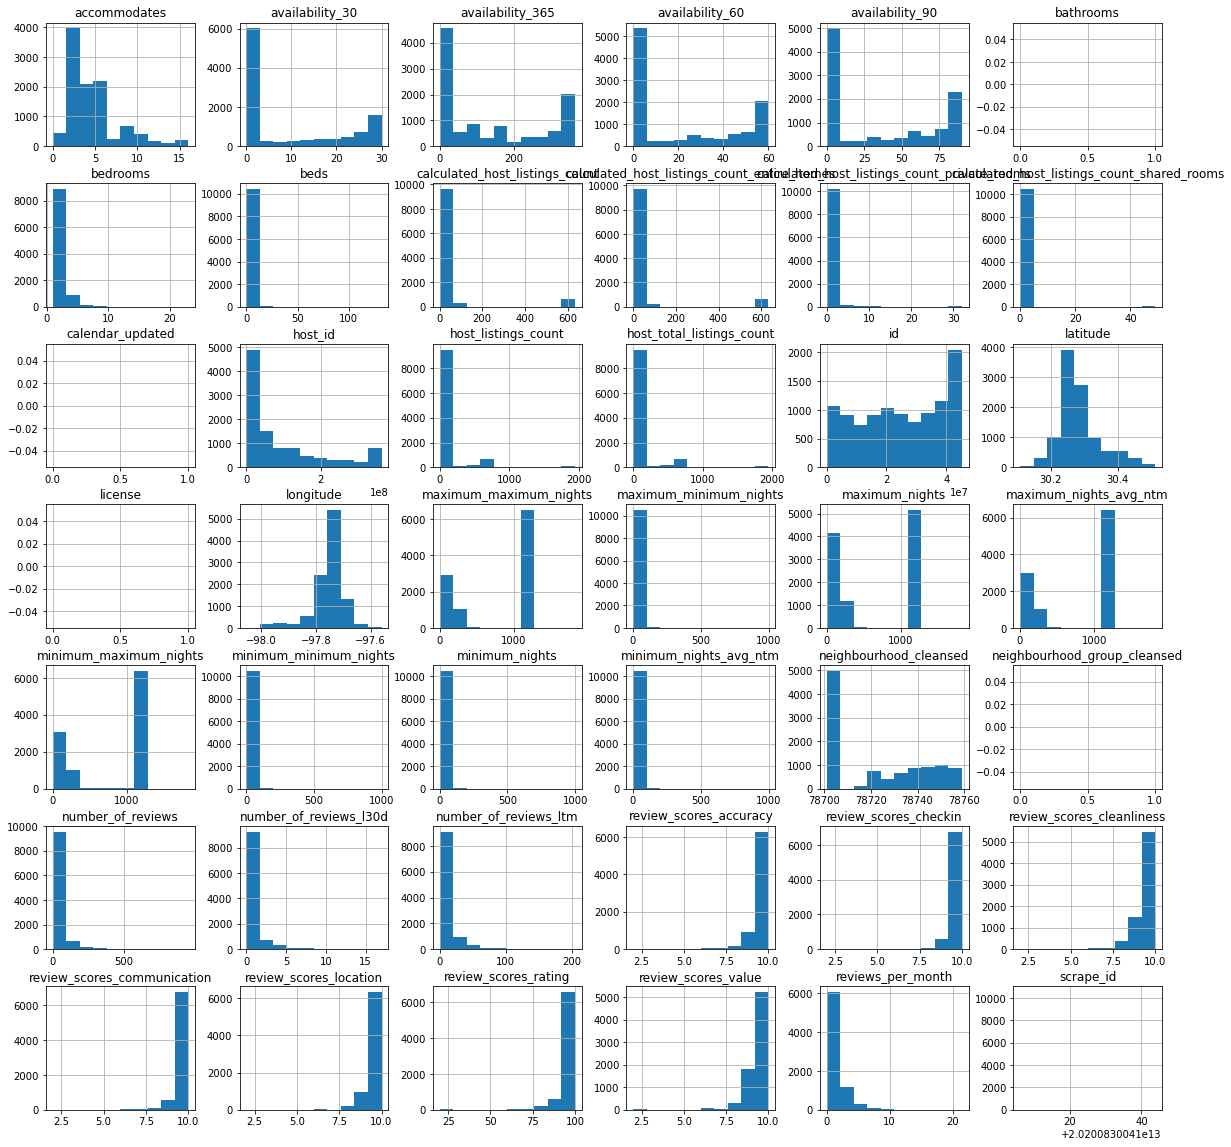

In [5]:
#Display histograms for various columns -- helps to detect empty columns among other things
df.hist(figsize=(20,20));

As seen in the histograms, columns such as 'bathrooms', 'license' etc. are completely empty and hence need to be dropped

In [6]:
# Shape for the 'df' dataframe
print(df.shape)

(10527, 74)


The dataset has 10527 rows and 74 columns

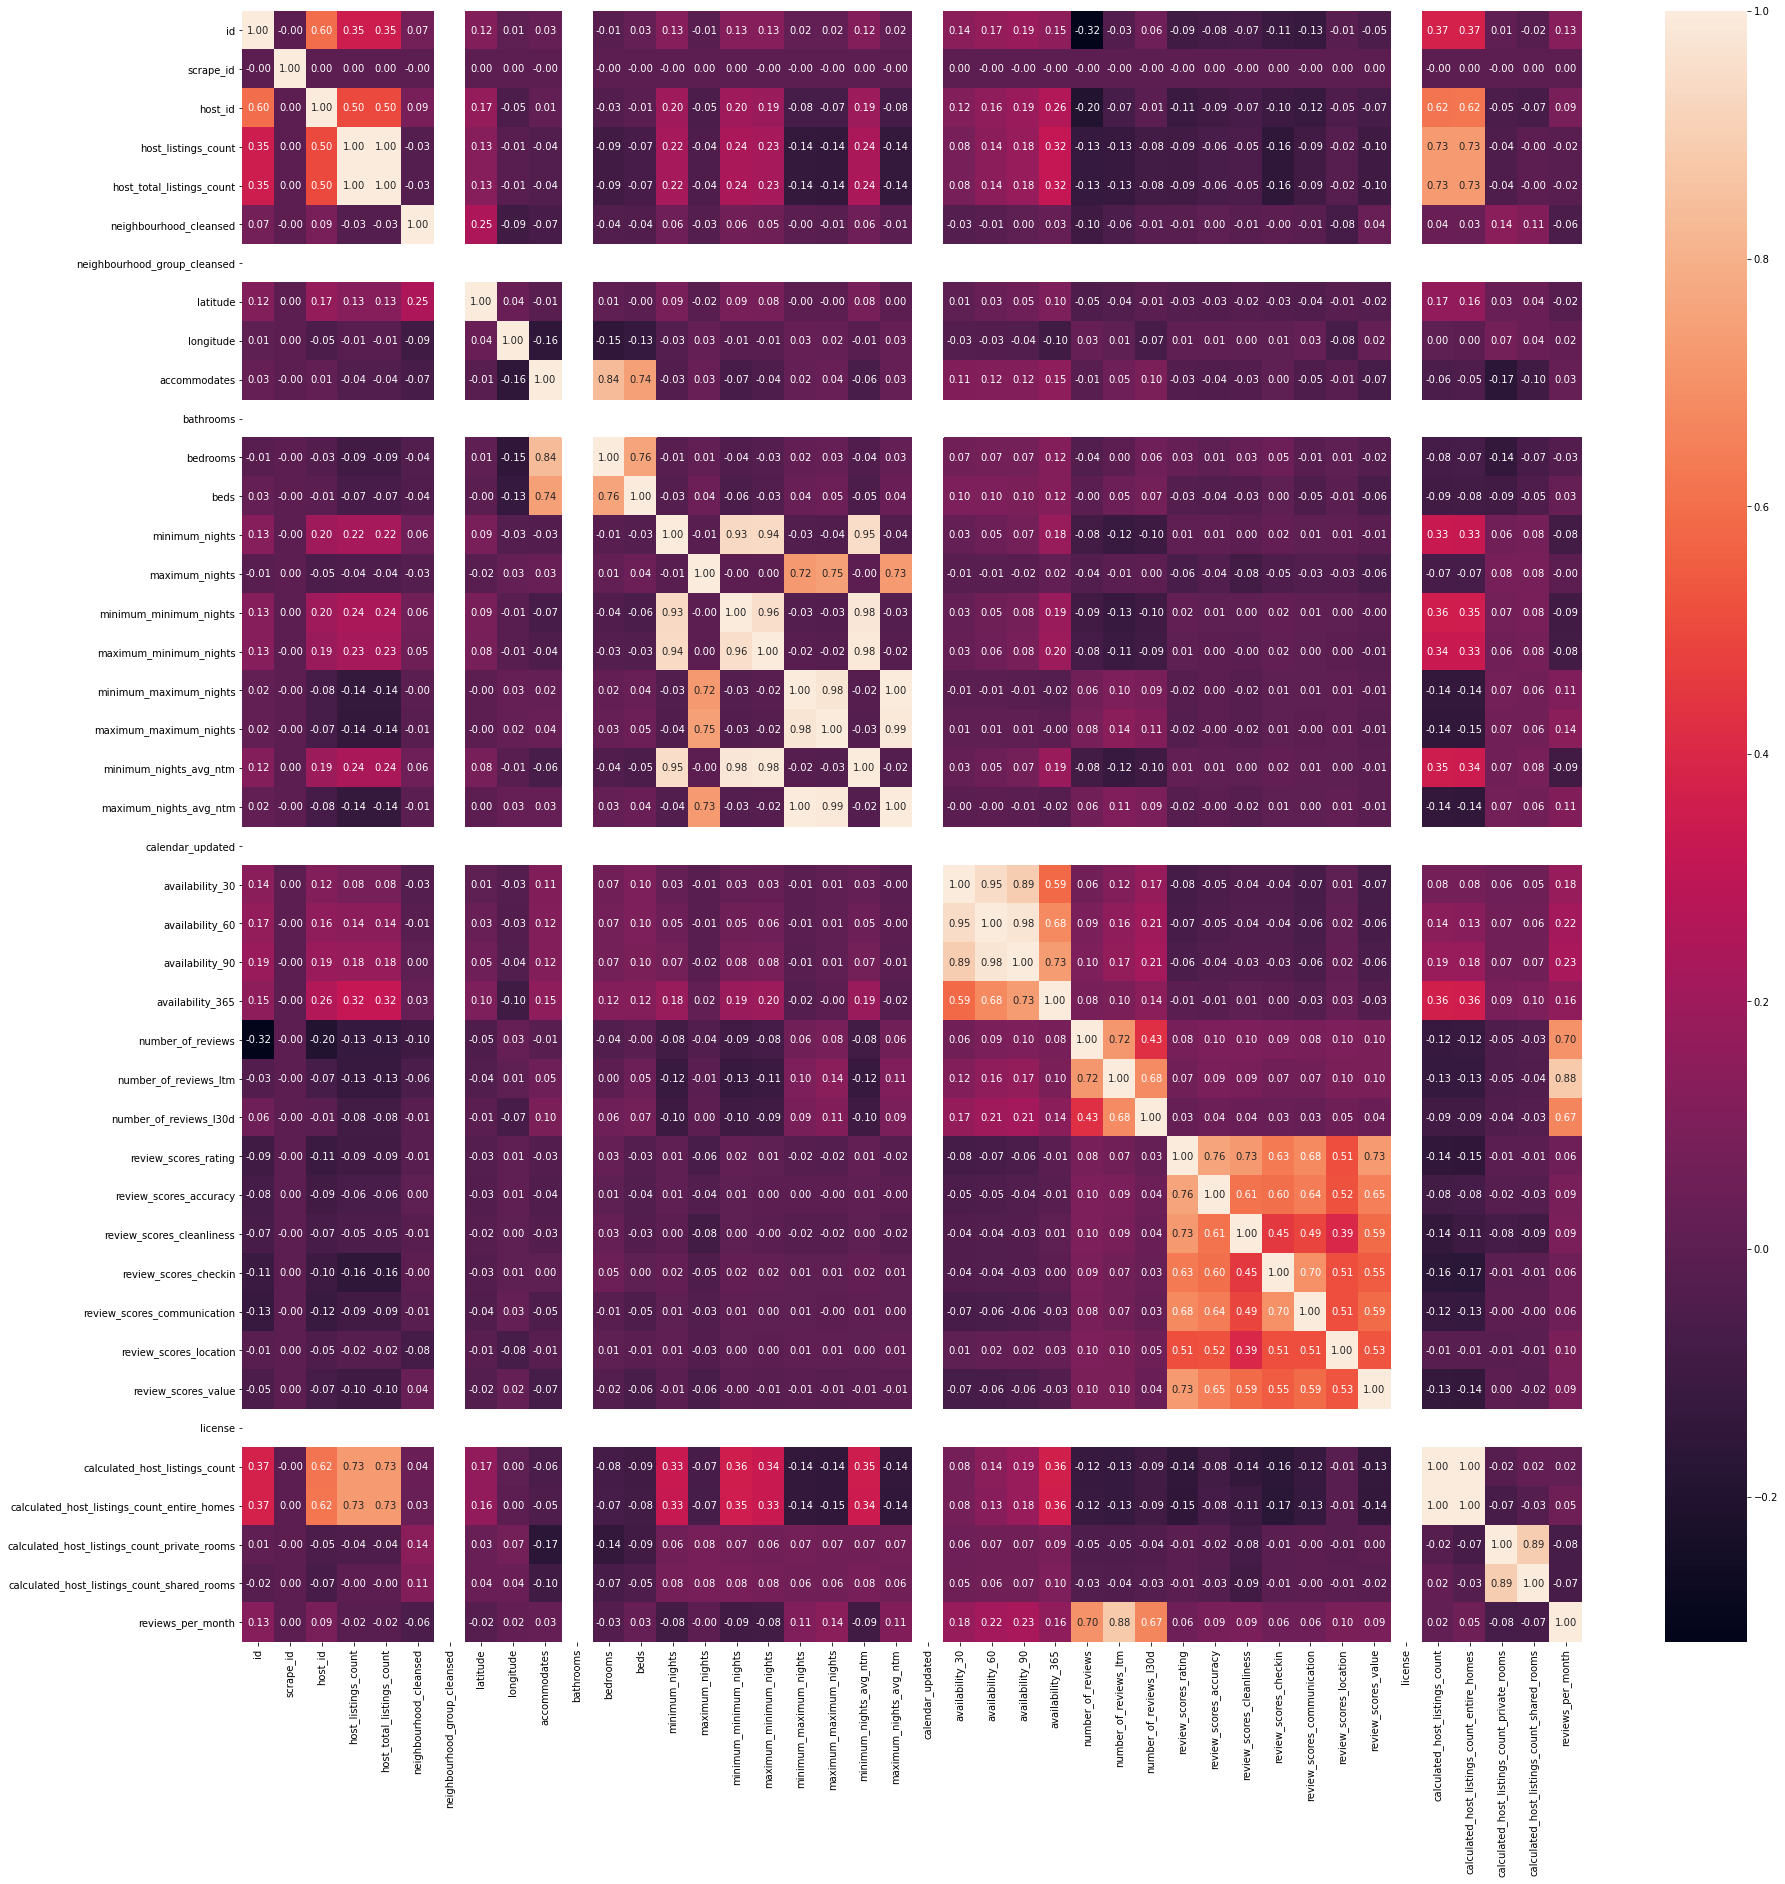

In [7]:
# Correlation heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot = True, fmt= '.2f')


Looks like there are some highly correlated features that could be candidates for being dropped

## Clean data

In [8]:
# Drop columns if column is completely empty
df = df.dropna(how = 'all', axis = 1)
print(df.shape)

(10527, 70)


4 columns were completely empty

In [9]:
# Drop columns that act as ids and not required for prediction
id_cols = ['name','description','host_neighbourhood', 'scrape_id', 'listing_url', 'id', 'host_id','picture_url', 'host_url','host_name', 'host_thumbnail_url','host_picture_url' ]
df = df.drop(id_cols, axis=1)
print(df.shape)

(10527, 58)


In [10]:
# Drop highly correlated features
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)
df = df.drop(df[to_drop], axis=1)
print(df.shape)

['host_total_listings_count', 'minimum_minimum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_60', 'availability_90', 'calculated_host_listings_count_entire_homes']
(10527, 49)


In [11]:
# Dropping categorical columns
cat_cols_to_drop = ['host_location','calendar_last_scraped','last_scraped', 'neighbourhood', 'neighborhood_overview', 'first_review', 'last_review','host_about']
df = df.drop(cat_cols_to_drop, axis = 1)

print(df.shape)

(10527, 41)


In [12]:
# Repurposing some columns 
df['host_acceptance_rate'] = df['host_acceptance_rate'].str[:-1]
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(float)
df['host_response_rate'] = df['host_response_rate'].str[:-1]
df['host_response_rate'] = df['host_response_rate'].astype(float)
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].astype(float)
df['price'] = df['price'].str[1:]
df['price'] = df['price'].str.replace(',','')
df['price'] = df['price'].astype(float)
gf['price'] = gf['price'].str[1:]
gf['price'] = gf['price'].str.replace(',','')
gf['price'] = gf['price'].astype(float)

Converting some columns to correct type and cleaning data inside them

In [13]:
# Filtering out rows that have more than 25% column values as NAs (i.e. 12 or more) and add the count as an attibute/feature
df['nan_count'] = df.isnull().sum(axis=1).sort_values(ascending = False)
df['nan_count'].sort_values(ascending = False)
df = df[(df.nan_count < 12)]
print(df.shape)

(10446, 42)


In [14]:
# Separating columns into categoricals and numericals for further analysis
cat_cols = df.select_dtypes(include='object').columns
print(cat_cols.shape)
print(cat_cols)

num_cols = df.select_dtypes(include=['number']).columns
print(num_cols.shape)
print(num_cols)


(12,)
Index(['host_since', 'host_response_time', 'host_is_superhost',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'property_type', 'room_type', 'bathrooms_text', 'amenities',
       'has_availability', 'instant_bookable'],
      dtype='object')
(30,)
Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_maximum_nights', 'availability_30', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_

In [15]:
#Get all cols that contains NAs
cols_have_na = df.columns[(df.isnull().sum() != 0)]
df[cols_have_na].isnull().sum().sort_values(ascending = False)

host_response_time             4055
host_response_rate             4055
host_acceptance_rate           3507
review_scores_location         2928
review_scores_value            2927
review_scores_communication    2923
review_scores_checkin          2923
review_scores_cleanliness      2922
review_scores_accuracy         2922
review_scores_rating           2879
reviews_per_month              2760
bedrooms                        608
beds                             36
bathrooms_text                    7
host_has_profile_pic              2
host_listings_count               2
host_is_superhost                 2
host_identity_verified            2
host_since                        2
dtype: int64

In [16]:
#Fill NAN values using different techniques for categorical and numerical columns
for c in cols_have_na:
    if c in num_cols:
        df[c].fillna(np.ceil(df[c].mean()), inplace = True)
    elif c in cat_cols:
        df[c].fillna(df[c].mode()[0], inplace = True)

Fill na with mean for numerical and mode for categorical

In [17]:
#Check that nans have been filled
df[cols_have_na].isnull().sum().sort_values(ascending = False)

reviews_per_month              0
bathrooms_text                 0
host_response_time             0
host_response_rate             0
host_acceptance_rate           0
host_is_superhost              0
host_listings_count            0
host_has_profile_pic           0
host_identity_verified         0
bedrooms                       0
review_scores_value            0
beds                           0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
host_since                     0
dtype: int64

In [18]:
print(df.shape)
print(df.columns)

(10446, 42)
Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_maximum_nights', 'has_availability', 'availability_30',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'r

In [19]:
df.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,nan_count
0,2008-08-23,within a day,100.0,100.0,t,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,78702.0,...,10.0,10.0,8.0,9.0,f,3,1,0,0.17,0
1,2008-08-23,within a day,100.0,100.0,t,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,78702.0,...,10.0,9.0,10.0,9.0,f,3,1,0,0.06,0
2,2009-02-16,within a few hours,100.0,94.0,t,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,78702.0,...,10.0,10.0,10.0,10.0,f,1,0,0,3.83,0
3,2009-01-27,within a few hours,70.0,88.0,f,1.0,"['email', 'phone', 'reviews']",t,f,78704.0,...,10.0,10.0,10.0,9.0,t,2,0,0,0.14,1
4,2009-02-19,within an hour,100.0,100.0,t,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,78729.0,...,10.0,10.0,10.0,10.0,f,1,1,0,2.03,0


In [20]:
# Creating new feature 'new_rating_avg' based on other columns that are related to rating
all_review_cols = ['review_scores_value','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location']
df['review_scores_rating'] = df['review_scores_rating'].div(10)
df['new_rating_avg'] = df[all_review_cols].mean(axis=1)
df = df.drop(all_review_cols, axis=1)

In [21]:
# Separate out year, month and day from host_since column
df['host_since' + '_year'] = pd.DatetimeIndex(df['host_since']).year
df['host_since' + '_month'] = pd.DatetimeIndex(df['host_since']).month
df['host_since' + '_day'] = pd.DatetimeIndex(df['host_since']).day
df = df.drop('host_since', axis = 1)

In [22]:
# Creating new feature 'count_host_verifications' for number of different verifications a host has
df['count_host_verifications'] = df['host_verifications'].str.strip(' ,[]').str.count(',') + 1
df = df.drop('host_verifications', axis = 1 )

In [23]:
# Creating new feature 'count_amenities' for number of different amenities that an airbnb offers
df['count_amenities'] = df['amenities'].str.strip(' ,[]').str.count(',') + 1

## Analyze Data

### Q.1 Do people staying at homes that have superhosts actually have better experiences, thus justifying the superhost's tag?

In [24]:
df.groupby('host_is_superhost')['new_rating_avg'].mean().sort_values(ascending = False)

host_is_superhost
t    9.896446
f    9.708761
Name: new_rating_avg, dtype: float64

As can be seen, people staying st superhosts' homes have better experiences than those who do not, based on the ratings that the people have given the host.

In [25]:
df.groupby('host_is_superhost')['accommodates'].mean().sort_values(ascending = False)

host_is_superhost
t    4.749516
f    4.519481
Name: accommodates, dtype: float64

The superhosts' are also found to be more accomodating than the non - superhosts, thus justifying better overall experiences for the customer

In [26]:
df.groupby('host_is_superhost')['host_acceptance_rate'].mean().sort_values(ascending = False)

host_is_superhost
t    91.954501
f    85.227273
Name: host_acceptance_rate, dtype: float64

Superhosts tend to have higher acceptance rate than non superhosts, thus leading to fewer cancellation from their ends and better customer experience

In [27]:
df.groupby('host_is_superhost')['host_response_rate'].mean().sort_values(ascending = False)

host_is_superhost
t    98.21999
f    94.09867
Name: host_response_rate, dtype: float64

Superhosts also have better response rate 

Hence, all in all, based on the various metrics seen above, people staying at a superhosts airbnb definitely have better experiences overall than those who do not

### Q2. What are the most common types of amenities offered at AirBNBs in Austin?

In [28]:
#Count the amenities offered at different airbnbs across Austin
amenities_ind_counts = pd.Series([x for item in df['amenities'].str.split(',') for x in item]).value_counts()
df = df.drop('amenities', axis = 1)

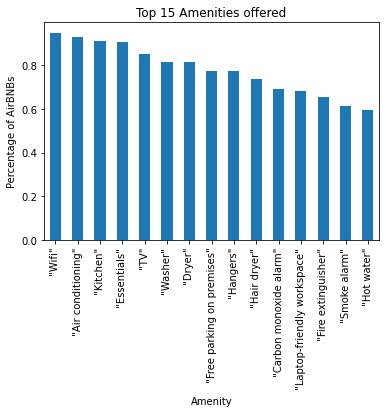

<Figure size 432x288 with 0 Axes>

In [29]:
#Calculate and plot the top 15 amenities offered at airbnbs across Austin based on the percentage of homes that offer it
amenities_perc = (amenities_ind_counts/df.shape[0])
top_15_amenities_perc = amenities_perc.head(15)
top_15_amenities_perc.plot(kind = 'bar', legend = None);
plt.title('Top 15 Amenities offered');
plt.xlabel('Amenity')
plt.ylabel('Percentage of AirBNBs')
plt.show()
plt.savefig('test.png')

## Model and Visualize

### Q.3 Is location a major factor that influences the price of an Airbnb?

In [30]:
# Separating columns into categoricals and numericals for further analysis
new_cat_cols = df.select_dtypes(include='object').columns
print(new_cat_cols.shape)
print(new_cat_cols)

new_num_cols = df.select_dtypes(include=['number']).columns
print(new_num_cols.shape)
print(new_num_cols)



(9,)
Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'property_type', 'room_type',
       'bathrooms_text', 'has_availability', 'instant_bookable'],
      dtype='object')
(29,)
Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'accommodates',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_maximum_nights', 'availability_30', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'calculated_host_listings_count',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'nan_count', 'new_rating_avg', 'host_since_year', 'host_since_month',
       'host_since_day', 'count_host_verifications', 'count_amenities'],
      dtype='object')


In [31]:
# Repurposing 'price' column to answer the Question i.e more than USD 150 or less than USD 150
df['price'].describe()
df['price'] = np.where(df['price'] > 150, 1, 0)

In [32]:
gf['price'] = np.where(gf['price'] > 150, 1, 0)

In [33]:
crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(gf['longitude'], gf['latitude'])]
geo_df = gpd.GeoDataFrame(gf,
 crs = crs,
 geometry = geometry)

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


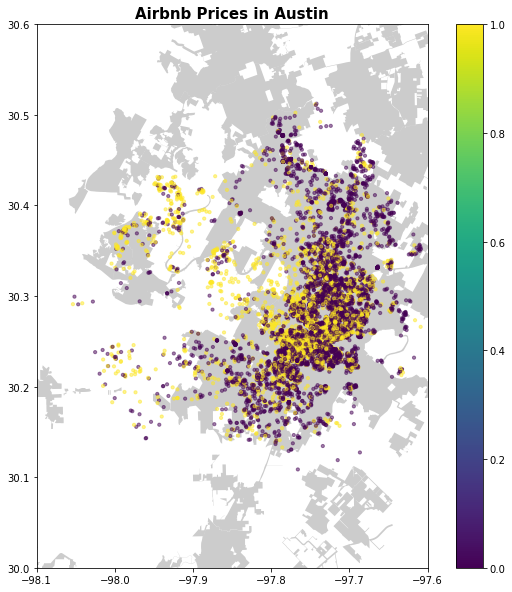

In [34]:
# create map of Austin to see distrbution of prices
fig, ax = plt.subplots(figsize=(10,10))
street_map.plot(ax=ax, alpha=0.4,color='grey')
geo_df.plot(column='price',ax=ax,alpha=0.5, legend=True,markersize=10)
plt.title('Airbnb Prices in Austin', fontsize=15,fontweight='bold')
plt.xlim(-98.1,-97.6)
plt.ylim(30,30.6)
plt.show()

The **yellow** dots in the plot show the Airbnbs that are priced above USD 150 whereas the **purple** dots show the airbnbs that cost less than USD 150. We can see that except a few locations, they overlap each other which suggests that although location is a factor, it is certainly not the most important one and we can confirm this when we do the prediction for the next question.

### Q4. Predict whether the Airbnb house is expensive (> USD 150) or not?

In [35]:
# Function to create multiple columns for each categorical variable and setting up 
# X(predictors) and Y(target)

def data_setup(df, new_num_cols, num_cat_cols):
    y = df['price']
    df = df.drop('price', axis=1)
    for c in new_cat_cols:
        df = pd.concat([df.drop(c, axis=1), pd.get_dummies(df[c], prefix=c, prefix_sep='_', drop_first=True)], axis=1)
    X = df
    return X,y

In [36]:
X, y = data_setup(df, new_num_cols, new_cat_cols)

In [37]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 40)

Accuracy score (training): 0.917
Accuracy score (testing): 0.862
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1197
           1       0.85      0.83      0.84       893

    accuracy                           0.86      2090
   macro avg       0.86      0.86      0.86      2090
weighted avg       0.86      0.86      0.86      2090



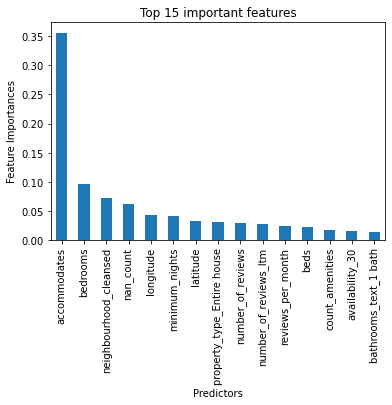

In [38]:
### Create a BASELINE MODEL for quick analysis of performance of Gradient Boosting Classifier

regr = GradientBoostingClassifier(n_estimators = 100 , learning_rate = 0.5, max_depth = 3)
model = regr.fit(X_train, y_train)
predictors_used = list(X_train)
feature_importances = pd.Series(model.feature_importances_, predictors_used).sort_values(ascending= False).head(15)
feature_importances.plot(kind = 'bar', title='Top 15 important features')
plt.xlabel('Predictors')
plt.ylabel('Feature Importances')

print("Accuracy score (training): {0:.3f}".format(model.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(model.score(X_test, y_test)))

pred=model.predict(X_test)
print(classification_report(y_test, pred))


In [39]:
# Tuning most important parameters: learning_rate and n_estimators

params = {
    'learning_rate':[0.5, 0.05, 0.005],
    'n_estimators': [50, 100, 200, 400]
}

trying_params = GridSearchCV(estimator = GradientBoostingClassifier(max_depth = 3, random_state=40), param_grid = params, scoring = 'accuracy', cv = 4)
trying_params.fit(X_train, y_train)
trying_params.best_params_, trying_params.best_score_

({'learning_rate': 0.05, 'n_estimators': 400}, 0.8443034944949737)

In [40]:
# Tuning 'max_depth'

params_2 = {
    'max_depth': [2,3,4],
}

trying_params = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=400, random_state=40), param_grid = params_2, scoring = 'accuracy', cv = 4)
trying_params.fit(X_train, y_train)
trying_params.best_params_, trying_params.best_score_

({'max_depth': 4}, 0.8490904739109622)

Accuracy score (training): 0.904
Accuracy score (testing): 0.870
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1197
           1       0.86      0.84      0.85       893

    accuracy                           0.87      2090
   macro avg       0.87      0.87      0.87      2090
weighted avg       0.87      0.87      0.87      2090



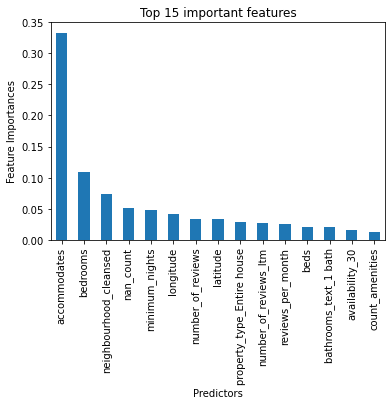

In [41]:
# Training updated model using best parameters found using Hyper Parameter Tuning
new_regr = GradientBoostingClassifier(n_estimators=400, learning_rate=0.05, max_depth=4, min_samples_split=50)
new_model = new_regr.fit(X_train, y_train)

predictors_used_new_model = list(X_train)
feature_importances = pd.Series(new_model.feature_importances_, predictors_used_new_model).sort_values(ascending= False).head(15)
feature_importances.plot(kind = 'bar', title='Top 15 important features')
plt.xlabel('Predictors')
plt.ylabel('Feature Importances')

print("Accuracy score (training): {0:.3f}".format(new_model.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(new_model.score(X_test, y_test)))

new_model_pred=new_model.predict(X_test)
print(classification_report(y_test, new_model_pred))



As can be seen, the number of true positives and true negatives, both have increased and the model performs better on the testing set, which is further compared in the ROC curve below

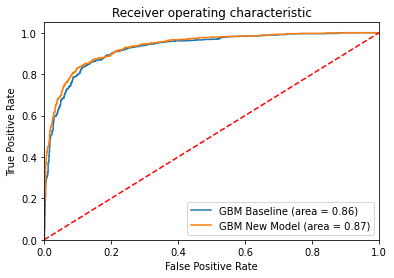

In [42]:
# Comparing ROC curves for both, baseline model vs new updated model
model_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fprB, tprB, thresholdsB = roc_curve(y_test, model.predict_proba(X_test)[:,1])

#new tuned model 
new_roc_auc = roc_auc_score(y_test, new_model.predict(X_test))
fprnew, tprnew, thresholds_new = roc_curve(y_test, new_model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fprB, tprB, label='GBM Baseline (area = %0.2f)' % model_roc_auc)
plt.plot(fprnew, tprnew, label='GBM New Model (area = %0.2f)' % new_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

Hence, we are able to predict 87% of the time on unseen data the correct answer for whetehr the airbnb is expensive or cheap.